# Step 1 loading data

In [1]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer, BertModel
import torch
import os


/Users/dave/Desktop/05_NLP/NLP_Contract_Checker/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = '../data/data_clean.pkl'
train_data_unlabeled = pd.read_pickle(path)

path = '../data/catalogue_clean.pkl'
cat = pd.read_pickle(path)

# Step 2 generalistic function for adding a coumn with emeddings


In [33]:
from tqdm import tqdm
import numpy as np

def embed_text_column(df, text_column, model, target_column, batch_size=16):
    """
    Berechnet SentenceTransformer-Embeddings spaltenweise (batchweise, CPU-optimiert).
    """
    texts = df[text_column].fillna("").tolist()
    all_embeddings = []

    for i in tqdm(range(0, len(texts), batch_size), desc=f"Embedding {text_column}"):
        batch = texts[i:i+batch_size]
        with torch.no_grad():
            emb = model.encode(batch, convert_to_tensor=True)
        all_embeddings.extend(emb.cpu().numpy())

    df[target_column] = all_embeddings
    return df



# Step 3 gespeicherte Models laden

In [4]:
# Pfad zum Modellordner
model_dir = "../models/raw_STM"

# Alle Modellpfade im Verzeichnis
model_paths = [os.path.join(model_dir, name) for name in os.listdir(model_dir) if os.path.isdir(os.path.join(model_dir, name))]

# Dictionary: Name (bis 2. "_") → geladenes Modell
models_dict = {}

for path in model_paths:
    basename = os.path.basename(path)
    model_name_parts = basename.split("_")
    short_name = "_".join(model_name_parts[:2])  # z. B. base_bert
    models_dict[short_name] = SentenceTransformer(path)

# Namen und Modelle ausgeben
list(models_dict.keys())


Some weights of the model checkpoint at ../models/raw_STM/base_jinai_sentence_mean_embs/ were not used when initializing BertModel: ['encoder.layer.5.mlp.layernorm.bias', 'encoder.layer.0.mlp.wo.weight', 'encoder.layer.8.mlp.layernorm.bias', 'encoder.layer.1.mlp.wo.bias', 'encoder.layer.5.mlp.wo.bias', 'encoder.layer.9.mlp.wo.bias', 'encoder.layer.1.mlp.layernorm.bias', 'encoder.layer.6.mlp.layernorm.bias', 'encoder.layer.7.mlp.layernorm.weight', 'encoder.layer.4.mlp.wo.weight', 'encoder.layer.10.mlp.layernorm.weight', 'encoder.layer.2.mlp.wo.weight', 'encoder.layer.7.mlp.layernorm.bias', 'encoder.layer.3.mlp.layernorm.weight', 'encoder.layer.3.mlp.wo.weight', 'encoder.layer.6.mlp.wo.weight', 'encoder.layer.0.mlp.wo.bias', 'encoder.layer.2.mlp.gated_layers.weight', 'encoder.layer.6.mlp.layernorm.weight', 'encoder.layer.3.mlp.gated_layers.weight', 'encoder.layer.6.mlp.wo.bias', 'encoder.layer.8.mlp.layernorm.weight', 'encoder.layer.11.mlp.gated_layers.weight', 'encoder.layer.8.mlp.wo.we

['multilingual_paraphrase', 'base_gbert', 'base_bert', 'base_jinai']

In [12]:
len(models_dict)

4

In [35]:

scores = []
best_matches  = []
worst_matches = []

import random
random.seed(2211)
sample = random.sample(range(len(train_data_unlabeled["clean_section_content"])), k =50)
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
train_data_labeled= train_data_unlabeled

for model_name in models_dict:
    model_selected = models_dict[model_name]
    train_data_labeled = embed_text_column(train_data_labeled.iloc[sample,:], text_column="clean_section_content",model = model_selected, target_column=f"section_em_{model_name}" )
    cat = embed_text_column(cat, text_column = "example", model = model_selected, target_column = "emb")
    train_data_labeled = train_data_labeled[["contract","paragraph","section","section_content",f"section_em_{model_name}" ]]
    X = np.vstack(train_data_labeled[f"section_em_{model_name}" ].values)  # Shape: [1400, 768]
    Y = np.vstack(cat["emb"].values)                  # Shape: [100, 768]

    # Cosine Similarity: alle Kombinationen
    similarity_matrix = cosine_similarity(X, Y)  # Shape: [1400, 100]
    similarity_percent = np.round(similarity_matrix * 100, 2)  # Skaliert zu 0–100 %

    best_match_idx = similarity_matrix.argmax(axis=1)
    best_match_score = similarity_percent[np.arange(len(X)), best_match_idx]

    # Ergebnisse anhängen
    train_data_labeled[f"matched_example_index_{model_name}"] = best_match_idx
    train_data_labeled[f"similarity_percent_{model_name}"] = best_match_score
    train_data_labeled[f"matched_example_text_{model_name}"] = cat.loc[best_match_idx, "example"].values
    train_data_labeled[f"matched_example_topic_{model_name}"] = cat.loc[best_match_idx, "section_topic"].values
    train_data_labeled[f"matched_paragraph_{model_name}"] = cat.loc[best_match_idx, "paragraph_topic"].values

    train_data_labeled = train_data_labeled.sort_values(f"similarity_percent_{model_name}", ascending = False)
    best_matches.append(f'best match: {train_data_labeled.iloc[0,3]} ### to ### {train_data_labeled[f"matched_example_text_{model_name}"]} ### with score ### {train_data_labeled[f"similarity_percent_{model_name}"]}')
    scores.append(train_data_labeled[f"similarity_percent_{model_name}"].to_list())
    train_data_labeled = train_data_labeled.sort_values(f"similarity_percent_{model_name}", ascending = True)
    worst_matches.append(f'worst match: {train_data_labeled.iloc[0,3]} ### to ### {train_data_labeled[f"matched_example_text_{model_name}"]} ### with score ### {train_data_labeled[f"similarity_percent_{model_name}"]}')
                                       
    
    print(f"# {model_name}")
    print("    mean:")
    print(train_data_labeled[f"similarity_percent_{model_name}"].mean())
    print("    max:")
    print(train_data_labeled[f"similarity_percent_{model_name}"].max()) 
    print("    min:") 
    print(train_data_labeled[f"similarity_percent_{model_name}"].min())







Embedding clean_section_content: 100%|██████████| 4/4 [00:42<00:00, 10.64s/it]
/var/folders/n9/9rvxcg4d1d15_3wh3wq9f0l40000gn/T/ipykernel_1122/3424113490.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target_column] = all_embeddings
Embedding example: 100%|██████████| 5/5 [00:24<00:00,  4.94s/it]


# multilingual_paraphrase
    mean:
77.34701
    max:
92.07
    min:
59.18


IndexError: positional indexers are out-of-bounds

4
4


/var/folders/n9/9rvxcg4d1d15_3wh3wq9f0l40000gn/T/ipykernel_1122/2033242429.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(scores, patch_artist=True, labels=model_names, flierprops=boxprops, medianprops=medianprops)


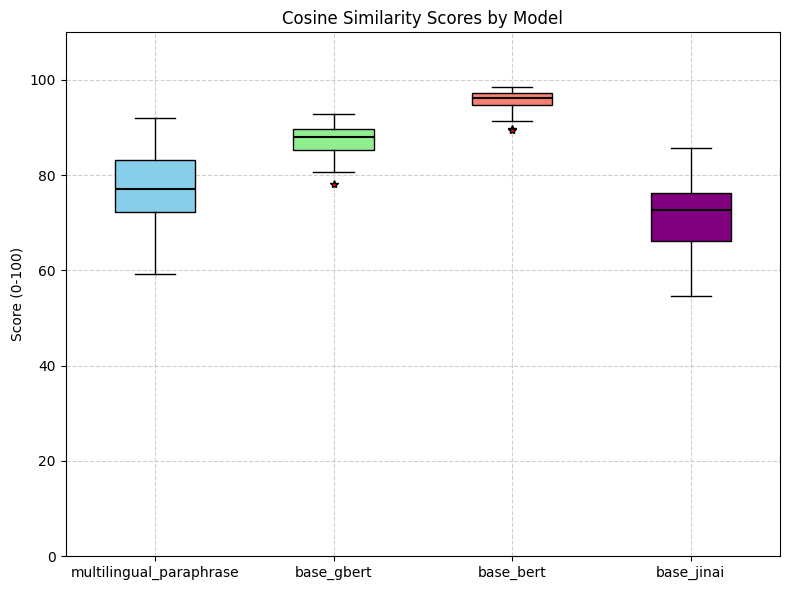

In [ ]:
import matplotlib.pyplot as plt

print(len(scores))
model_names = models_dict.keys()
print(len(model_names))
box_colors = ['skyblue', 'lightgreen', 'salmon','purple']

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
boxprops = dict(markerfacecolor='red', marker='*', linestyle='-', linewidth=1.5)
medianprops = dict(color='black', linewidth=1.5)

bp = ax.boxplot(scores, patch_artist=True, labels=model_names, flierprops=boxprops, medianprops=medianprops)

# Farben setzen
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)

# Titel und Achsen
ax.set_title('Cosine Similarity Scores by Model')
ax.set_ylabel('Score (0-100)')
ax.set_ylim(0, 110)

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()




In [30]:
model_names = list(models_dict.keys())
for i in range(4):
    print(model_names[i])
    #print(model_dir[model_names[i]])
    print("best match:")
    print(best_matches[i])
    print("worst match:")
    print(worst_matches[i])
    print("#########")

multilingual_paraphrase
best match:
best match: (1) Die Parteien sind verpflichtet, alle ihnen im Zusam- menhang mit diesem Vertrag bekannt gewordenen o- der bekannt werdenden Informationen über die jeweils andere Partei, die als vertraulich gekennzeichnet wer- den oder anhand sonstiger Umstände als Geschäfts- und Betriebsgeheimnisse (im Folgenden: "vertrauliche Informationen") erkennbar sind, dauerhaft geheim zu halten, nicht an Dritte weiterzugeben, aufzuzeichnen o- der in anderer Weise zu verwerten, sofern die jeweils andere Partei der Offenlegung oder Verwendung nicht ausdrücklich und schriftlich zugestimmt hat oder die In- formationen aufgrund Gesetzes, Gerichtsentschei- dung oder einer Verwaltungsentscheidung offengelegt werden müssen. ### to ### Die Parteien verpflichten sich alle ihnen im Rahmen dieses Vertrags zugänglich werdenden vertraulichen Informationen streng vertraulich zu behandeln und ausschließlich für die vertraglich vorgesehenen Zwecke zu verwenden Diese Geheimhalt

Embedding clean_section_content: 100%|██████████| 4/4 [00:19<00:00,  4.79s/it]
/var/folders/n9/9rvxcg4d1d15_3wh3wq9f0l40000gn/T/ipykernel_7528/1283774044.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target_column] = all_embeddings
Embedding example: 100%|██████████| 3/3 [00:12<00:00,  4.01s/it]


In [ ]:
train_data_unlabeled = train_data_unlabeled[["contract","paragraph","section","section_content","section_emb_jinai"]]
display(train_data_unlabeled.head())
cat

,contract,paragraph,section,section_content,section_emb_jinai
0,1,§ 1,1.1,1.1 Der Anbieter stellt dem Kunden die Softwar...,"[-0.10569506, -0.35552627, -0.20494811, -0.293..."
1,1,§ 1,1.2,1.2 Die Nutzung umfasst die Bereitstellung von...,"[-0.19359303, -0.1972066, -0.17978719, 0.05164..."
2,1,§ 1,1.3,1.3 Der Kunde erhält ausschließlich das vertra...,"[0.052544694, 0.015130943, -0.26078856, -0.116..."
3,2,§ 1,(1),(1) Dieser Software-as-a-Service-Vertrag ist a...,"[-0.3132257, -0.3315126, -0.31846762, -0.00320..."
4,2,§ 1,(2),(2) Die Software wird vom Anbieter als webbasi...,"[-0.18824683, -0.30838844, -0.36689153, -0.217..."


,paragraph_topic,section_topic,example,example_emb_jinai
0,Projektkosten_und_Zahlungsmodalitäten,Sind sämtliche Kostenarten und -bestandteile (...,Im Festpreis von € sind sämtliche Leistungen e...,"[-0.04878292, -0.033862136, -0.14431074, -0.03..."
1,Projektkosten_und_Zahlungsmodalitäten,Ist das Vergütungsmodell eindeutig festgelegt ...,Der Kunde zahlt eine monatliche Pauschale von ...,"[0.033271167, -0.014793341, -0.087332174, -0.1..."
2,Projektkosten_und_Zahlungsmodalitäten,Ist ein Zahlungsplan mit konkreten Fälligkeite...,Die Vergütung ist in drei Raten zahlbar 30 bei...,"[0.12990442, 0.16633622, -0.09211009, -0.12854..."
3,Projektkosten_und_Zahlungsmodalitäten,"Sind Währung, Rechnungsstellung, Zahlungsfrist...",Alle Preise verstehen sich in Euro zuzüglich g...,"[-0.023702992, 0.22317427, -0.33675542, -0.092..."
4,Projektkosten_und_Zahlungsmodalitäten,Regelt der Vertrag den Umgang mit Nebenkosten ...,Reise und Übernachtungskosten werden nur ersta...,"[-0.0011078225, 0.06999768, -0.11404526, 0.064..."
...,...,...,...,...
71,Sonstige_wichtige_Klauseln,Ist die anwendbare Rechtsordnung eindeutig ver...,Dieser Vertrag unterliegt dem Recht der Bundes...,"[-0.15282267, 0.31433058, -0.24742366, 0.10590..."
72,Sonstige_wichtige_Klauseln,Ist ein Gerichtsstand für Streitigkeiten festg...,Gerichtsstand für alle Streitigkeiten aus oder...,"[-0.04493618, 0.5619757, -0.31465572, -0.17154..."
73,Sonstige_wichtige_Klauseln,"Bei mehrsprachigen Verträgen: Ist festgelegt, ...",Dieser Vertrag wird in deutscher und englische...,"[0.057327263, 0.3142493, -0.09877414, -0.07086..."
74,Sonstige_wichtige_Klauseln,Enthält der Vertrag eine salvatorische Klausel...,Sollte eine Bestimmung dieses Vertrages unwirk...,"[-0.1312876, 0.14200835, -0.19419987, -0.03389..."


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Matrizen aus Embedding-Listen bauen
X = np.vstack(train_data_unlabeled["section_emb_jinai"].values)  # Shape: [1400, 768]
Y = np.vstack(cat["example_emb_jinai"].values)                  # Shape: [100, 768]

# Cosine Similarity: alle Kombinationen
similarity_matrix = cosine_similarity(X, Y)  # Shape: [1400, 100]
similarity_percent = np.round(similarity_matrix * 100, 2)  # Skaliert zu 0–100 %



In [ ]:
best_match_idx = similarity_matrix.argmax(axis=1)
best_match_score = similarity_percent[np.arange(len(X)), best_match_idx]

# Ergebnisse anhängen
train_data_unlabeled["matched_example_index"] = best_match_idx
train_data_unlabeled["similarity_percent"] = best_match_score
train_data_unlabeled["matched_example_text"] = cat.loc[best_match_idx, "example"].values
train_data_unlabeled["matched_example_topic"] = cat.loc[best_match_idx, "section_topic"].values
train_data_unlabeled["matched_paragraph"] = cat.loc[best_match_idx, "paragraph_topic"].values

display(train_data_unlabeled.head())
print(train_data_unlabeled.iloc[3,3])
print(f"-->{train_data_unlabeled.iloc[3,7]}")
print(train_data_unlabeled["similarity_percent"].mean())


,contract,paragraph,section,section_content,section_emb_jinai,matched_example_index,similarity_percent,matched_example_text,matched_example_topic,matched_paragraph
0,1,§ 1,1.1,1.1 Der Anbieter stellt dem Kunden die Softwar...,"[-0.10569506, -0.35552627, -0.20494811, -0.293...",27,56.169998,Der Anbieter sichert eine Verfügbarkeit des Cl...,Wird eine Mindestverfügbarkeit des SaaS-Dienst...,Service-Level-Agreements_(SLAs)
1,1,§ 1,1.2,1.2 Die Nutzung umfasst die Bereitstellung von...,"[-0.19359303, -0.1972066, -0.17978719, 0.05164...",9,48.000000,Der Anbieter liefert im Rahmen dieses Projekts...,Sind alle zu erbringenden Lieferungen und Leis...,Leistungsbeschreibung_und_Deliverables
2,1,§ 1,1.3,1.3 Der Kunde erhält ausschließlich das vertra...,"[0.052544694, 0.015130943, -0.26078856, -0.116...",46,77.680000,Individuelle Entwicklungen die der Anbieter im...,"Wird geregelt, wem neu entstehende Arbeitserge...",Rechte_und_Pflichten_der_Vertragsparteien
3,2,§ 1,(1),(1) Dieser Software-as-a-Service-Vertrag ist a...,"[-0.3132257, -0.3315126, -0.31846762, -0.00320...",9,53.779999,Der Anbieter liefert im Rahmen dieses Projekts...,Sind alle zu erbringenden Lieferungen und Leis...,Leistungsbeschreibung_und_Deliverables
4,2,§ 1,(2),(2) Die Software wird vom Anbieter als webbasi...,"[-0.18824683, -0.30838844, -0.36689153, -0.217...",12,56.439999,Im Leistungsumfang enthalten ist die Entwicklu...,Werden geplante Schnittstellen zu Dritt-System...,Leistungsbeschreibung_und_Deliverables


(1) Dieser Software-as-a-Service-Vertrag ist auf On- line-Bestellungen anwendbar.
-->Der Anbieter liefert im Rahmen dieses Projekts folgende Leistungen Installation und Konfiguration der ERPSoftware in der aktuellen Version Entwicklung der Schnittstelle zum Webshop Migration der Altdaten Stammdaten und offene Posten zwei AdminSchulungen für die IT des Kunden sowie eine deutschsprachige Anwenderdokumentation
64.22289


In [ ]:
display(train_data_
        labeled.head())

NameError: name 'train_data_labeled' is not defined